# RA2CE feature: Equity analysis

This notebook is a rather technical notebook. The recommended user is a user with background knowledge of network criticality. 

In this notebook, we will perform criticality analysis with three different distributive principles: utilitarian, egalitarian and prioritarian principles. For more background knowledge on these principles and the application on transport network criticality analysis, please read: https://www.sciencedirect.com/science/article/pii/S0965856420308077 

The purpose of the equity analysis performd in this notebook is providing insight into how different distributive principles can result in different prioritizations of the network. While we usually prioritize network interventions based on the number of people that use the road, equity principles allow us to also take into account the function of the network for for example underpriviliged communities. 
Depending on the equity principle applied, your network prioritization might change, which can change decision-aking.

The RA2CE analysis is set up generically. The user can determine the equity weights themselves. This can for example be GINI-coefficients or social vulnerability scores. The user-defined equity weights will feed into the prioritarian principle.

The three applied principles are explained below:

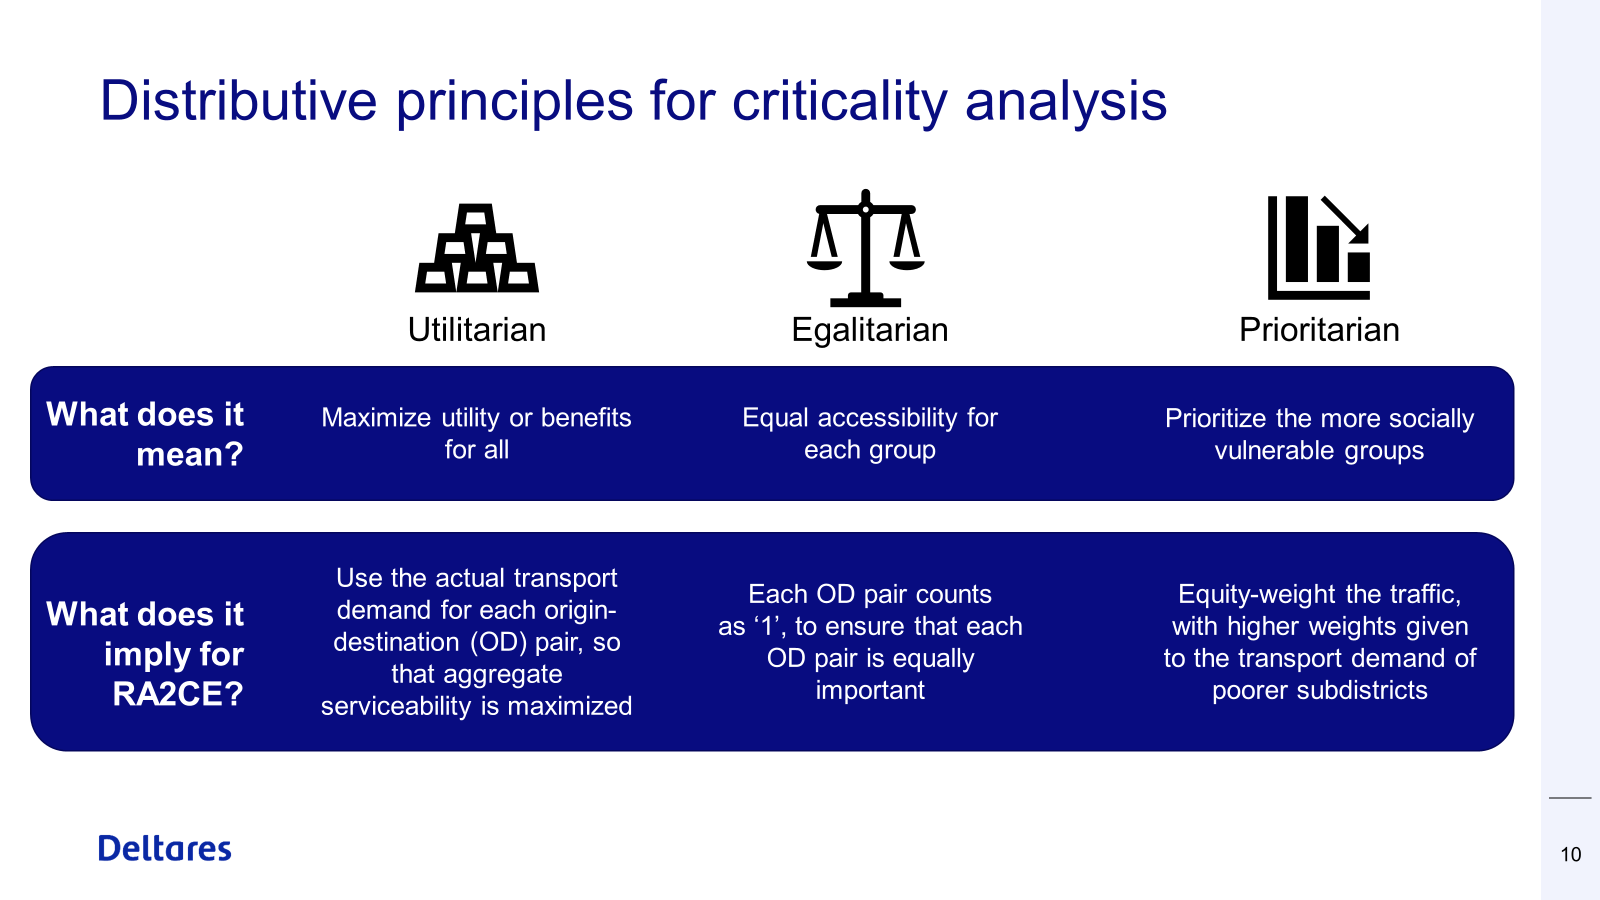

### For new users

If you have not checked out the previous RA2CE examples and you want to run your own RA2CE analysis, we advise you to first familiarize yourself with those notebooks. In this current notebook we will not provide extensive explanations as to how to run RA2CE and create the correct setups. We will assume the user has this knowledge already. 

## Imports

Packages import

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import folium


from pathlib import Path

from ra2ce.analysis.analysis_config_data import EquityConfigData
from ra2ce.analysis.analysis_config_data.analysis_config_data import AnalysisConfigData
from ra2ce.analysis.analysis_config_data.enums.weighing_enum import WeighingEnum
from ra2ce.network.network_config_data.enums.road_type_enum import RoadTypeEnum
from ra2ce.network.network_config_data.enums.network_type_enum import NetworkTypeEnum
from ra2ce.network.network_config_data.enums.source_enum import SourceEnum
from ra2ce.network.network_config_data.network_config_data import (
    NetworkSection, NetworkConfigData, OriginsDestinationsSection
)
from ra2ce.ra2ce_handler import Ra2ceHandler

# Specify the path to your RA2CE project folder and input data
root_dir = Path("data", "equity_analysis")
network_path = root_dir.joinpath('static', 'network')

Set the path to your equity analysis data folder

## Inspect data and get familiar with the use-case

We will first show you the data that will be used in this use case on Pontianak Indonesia

### 1. Using equity weights to delineate more vulnerable areas

For the equity analysis, the user can assign equity weights which can be used in the criticality analysis. In this analysis we use a region weights file (region_weight.csv) which holds weights for specific areas in Pontianak Indonesia. You then also need a shapefile delineating the regions in question. We will inspect both files in this example and see which areas of Pontianak are more vulnerable according to this user-specified equity-weight file

In [ ]:
# load the files
path_network = root_dir / "static" / "network"
path_region_weights = path_network / "region_weight.csv"
path_regions = path_network / "region.shp"

region_weigths = pd.read_csv(path_region_weights, sep=';')
regions = gpd.read_file(path_regions, driver = "SHP")

#Merge the shapefile and the weights csv file:
region_weights_plot = pd.merge(regions, region_weigths, left_on='DESA', right_on='region')

Which regions are more vulnerable?

In [ ]:
#Inspect the regions
region_weights_plot.explore(column='weight', cmap='Reds', tiles="CartoDB positron")

### 2. Inspect origins, destinations and the road network

Load the origins and destinations data and the road network of our analysis

In [ ]:
path_network = root_dir / "static" / "network"
path_origins = path_network / "origins_points.shp"
path_destinations = path_network / "osm_health_point.shp"
origins = gpd.read_file(path_origins, driver = "SHP")
destinations = gpd.read_file(path_destinations, driver = "SHP")

Inspect origins (blue) and health destinations (red)

In [ ]:
m = origins.explore(color='blue', tiles="CartoDB positron", name='WorldPop origins')
m = destinations.explore(m=m, color="red", name="Health destinations")
# this is completely optional
folium.LayerControl().add_to(m)
m

## Running the RA2CE analysis

### 1. Make sure your data is created and stored correctly

See the origins/destinations example to familiarize yourself with how to set up origins and destinations files. Inspect the regions file and the region_weight file and make sure they are saved in the correct folder

### 2. Set up your network and analysis ini

Before you start running, you need to make sure that your .ini files contain the right parameters. Check out the analysis and network.ini files in the data folder to check the additional parameters that need to be set to run this example! Below we paste a snippet of these files as example

**Network Ini update section origins_destinations**<br>

>[origins_destinations]<br>
origins = origins_points.shp # Must be in the static/network folder, belongs to this analysis <br>
destinations = osm_health_point.shp # gis_osm_pois_pontianak.shp # Must be in the static/network folder, belongs to this analysis<br>
origins_names = A<br>
destinations_names = B<br>
id_name_origin_destination = OBJECTID #default if origins is a tif file = OBJECTID<br>
origin_count = values #necessary if traffic on each edge would be recorded in optimal_route_origin_destination<br>
origin_out_fraction = 1<br>
category = category<br>
region = region.shp #necessary for distributional / equity analysis<br>
region_var = DESA #necessary for distributional / equity analysis<br>

**analysis_ini update optimal_route_origin_destination analysis**<br>

>[analysis1]<br>
name = optimal route origin destination<br>
analysis = optimal_route_origin_destination<br>
weighing = length<br>
save_traffic = True #True if you want to record the traffic in each edge<br>
equity_weight = region_weight.csv #equity-weighted factors for each region, should be stored in static/network. Note that 'region' and 'region_var' should present in network.ini<br>
save_gpkg = True<br>
save_csv = True<br>



### 3. Find your folder and initalization files

Now we can start our RA2CE analysis. Let's initialize RA2CE first

In [ ]:
from ra2ce.ra2ce_handler import Ra2ceHandler #import the ra2cehandler to run ra2ce analyses

network_section = NetworkSection(
    directed=False,
    source=SourceEnum.OSM_DOWNLOAD,
    polygon=network_path.joinpath("Pontianak_4326_buffer_0_025deg.geojson"),
    network_type=NetworkTypeEnum.DRIVE,
    road_types=[
        RoadTypeEnum.MOTORWAY,
        RoadTypeEnum.MOTORWAY_LINK,
        RoadTypeEnum.PRIMARY,
        RoadTypeEnum.PRIMARY_LINK,
        RoadTypeEnum.SECONDARY,
        RoadTypeEnum.SECONDARY_LINK,
        RoadTypeEnum.TERTIARY,
        RoadTypeEnum.TERTIARY_LINK,
    ],
    save_gpkg=True,
    reuse_network_output=True,
)


origin_destination_section = OriginsDestinationsSection(
    origins=network_path.joinpath("origins_points.shp"),
    destinations=network_path.joinpath("osm_health_point.shp"),
    origin_count="values",
    category="category",
    region=network_path.joinpath("region.shp"),
    region_var="DESA"
)

In [ ]:
network_config_data = NetworkConfigData(
    root_path=root_dir,
    static_path=root_dir.joinpath('static'),
    network=network_section,
    origins_destinations=origin_destination_section,
)

In [ ]:
analyse_section = EquityConfigData(
    name="Optimal Route OD equity",
    weighing=WeighingEnum.LENGTH,
    calculate_route_without_disruption=True,
    equity_weight=network_config_data.static_path.joinpath("network", "region_weight.csv"),
    save_csv=True,
    save_gpkg=True,
)

analysis_config_data = AnalysisConfigData(
    output_path=root_dir.joinpath("output"),
    static_path=root_dir.joinpath('static'),
    analyses=[analyse_section],
)

Check if the network.ini and analysis.ini indeed exist

In [ ]:
handler = Ra2ceHandler.from_config(
    network=network_config_data,
    analysis=analysis_config_data
)
handler.configure()
handler.run_analysis()

## Post-processing results

The result of the equity analysis will be saved into the 'output' folder, under the specified analysis 'optimal_route_origin_destination'. This is a .csv file without geometry. To plot the results below, we will first add geometry to this data prior to showing the results

####  1. Load the traffic analysis output data

In [ ]:
optimal_route = root_dir/'output'/'equity'
optimal_route_graph = optimal_route / "Optimal_Route_OD_equity_link_traffic.csv"
traffic = pd.read_csv(optimal_route_graph)
df = traffic.copy()
df.head()

#### 2. Load the origin_destination graph edges that hold geometry

In [ ]:
path_output_graph = root_dir / "static" / "output_graph"
base_graph_edges = path_output_graph / "origins_destinations_graph_edges.gpkg"
edges_gdf = gpd.read_file(base_graph_edges, driver = "GPKG")
gdf = edges_gdf.copy()
edges_gdf.head()

#### 3. Merge analysis data with geometry 

In [ ]:
for var in ['traffic', 'traffic_egalitarian', 'traffic_prioritarian']:
    gdf[var] = 0
    
    # Create a dictionary to store the values for faster lookup
    var_values = dict(zip(zip(df['u'], df['v']), df[var]))

    for u, v in zip(df['u'], df['v']):
        if u != v:
            # Check if the edge (u, v) exists in the DataFrame
            if (u, v) in var_values:
                gdf.loc[(gdf['u'] == u) & (gdf['v'] == v), var] = var_values[(u, v)]
                
                # Check if the reverse edge (v, u) exists and hasn't been assigned a value yet
                if (v, u) not in var_values:
                    gdf.loc[(gdf['u'] == v) & (gdf['v'] == u), var] = var_values[(u, v)]
            else:
                # If the edge doesn't exist in the DataFrame, check if the reverse edge does
                if (v, u) in var_values:
                    gdf.loc[(gdf['u'] == v) & (gdf['v'] == u), var] = var_values[(v, u)]


#### 4. Rank the edges based on the different traffic analysis results

In [ ]:
gdf['traffic_ranked'] = gdf['traffic'].rank(method='min', ascending=False)
gdf['traffic_egalitarian_ranked'] = gdf['traffic_egalitarian'].rank(method='min', ascending=False)
gdf['traffic_prioritarian_ranked'] = gdf['traffic_prioritarian'].rank(method='min', ascending=False)

## Visualize results

The darker the edge, the higher its ranking, the more critical the network part 

Ranking 1 is the highest ranking, higher values represent lower rankings

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
gdf.plot(column='traffic_ranked',cmap='gist_heat',ax=axs[0],legend=True)
axs[0].set_title('Utilitarian principle ranking')
gdf.plot(column='traffic_egalitarian_ranked', cmap='gist_heat', ax=axs[1], legend=True)
axs[1].set_title('Egalitarian principle ranking')
gdf.plot(column='traffic_prioritarian_ranked', cmap='gist_heat',ax=axs[2], legend=True)
axs[2].set_title('Prioritarian principle ranking')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

What does this tell us?

The higher the ranking of an edge (values closer to 1), the more critical that part of the network, given the equity principle applied. In the utilitarian principle, this means the most people using that edge. In the egalitarian principle it means having each origin-destination pair having equal opportunity to acces, regardless of how many people live in one origin. In the last principle we correct for the provided equity weight and base the travel calculations on that. This prioritizes more vulnerable areas. 

These insights can be used to for example prioritize network investments. Depending on the service of the network, the prioritization of investments can shift. If investments were to be done based on serving underpiviliged communities, the prioritarian ranking principle can be used, utilizing weights that represent priviliged and underpriviliged areas/communities/regions. As the user is free to specify their own 'equity weights', they can determine their own criteria for prioritization of areas. 

In [ ]:
gdf.explore(column='traffic_prioritarian_ranked', tiles="CartoDB positron", cmap='gist_heat')